# Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from sklearn.model_selection import GroupShuffleSplit
import xgboost as xgb
from sklearn.metrics import ndcg_score, dcg_score

In [3]:
import riotwatcher
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import graphviz

# Helper Function

In [4]:
def predict(model, df):
    return model.predict(df.loc[:, ~df.columns.isin(['MATCH_ID'])])

In [6]:
9-np.array([1,2,3,4])

array([8, 7, 6, 5])

In [7]:
def avg_ndcg(true, predicts):
    
    ndcg_scores = []
    
    for match in predicts.index:
        predicted_placement = np.asarray([sorted(predictions.loc[match], reverse=True).index(placement) for placement in predictions.loc[match]]).reshape(1,-1)
        actual_placement = (9-np.asarray(true[true['MATCH_ID'] == match]['placement'].values)).reshape(1,-1)
        try:
            ndcg_scores.append(ndcg_score(predicted_placement, actual_placement))
        except:
            pass
    
    return np.mean(ndcg_scores)

In [31]:
def null_ndcg(true, predicts):
    
    ndcg_scores = []
    
    for match in predicts.index:
#         arr = np.arange(1,9)
#         np.random.shuffle(arr)
#         arr
        predicted_placement = np.flip(np.arange(1,9)).reshape(1,-1)
        actual_placement = np.asarray(true[true['MATCH_ID'] == match]['placement'].values).reshape(1,-1)
        try:
            ndcg_scores.append(ndcg_score(predicted_placement, actual_placement))
        except:
            pass
    
    return np.mean(ndcg_scores)

# XGBRanker

In [8]:
df = pd.read_csv('../datasets/processed/matches.csv')

In [9]:
df.shape

(253000, 159)

In [10]:
df.head()

MATCH_ID  gold_left  level  placement  players_eliminated  \
0  NA1_4203444536          9      8          2                   1   
1  NA1_4203444536          0      8          6                   0   
2  NA1_4203444536          2      8          1                   2   
3  NA1_4203444536         90      8          4                   0   
4  NA1_4203444536          1      8          5                   2   

   total_damage_to_players  Set6_Twinshot_count  \
0                      135                  0.0   
1                       49                  1.0   
2                      192                  0.0   
3                      123                  0.0   
4                       89                  2.0   

   TFTTutorial_Blademaster_count  TFTTutorial_Assassin_count  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            0.0                         0.0   

   Set6_Bodyguard_count  ...  TFT6_Ziggs  TFT6_Swain  TFT6_Galio  \
0                   0.0  ...         1.0         1.0         0.0   
1                   0.0  ...         0.0         0.0         0.0   
2                   1.0  ...         1.0         0.0         0.0   
3                   0.0  ...         0.0         0.0         0.0   
4                   0.0  ...         0.0         0.0         0.0   

   TFT6_Trundle  TFT6_Shaco  TFT6_ChoGath  TFT6_Akali  TFT6_Veigar  \
0           0.0         0.0           0.0         0.0          0.0   
1           0.0         0.0           1.0         0.0          0.0   
2           0.0         0.0           0.0         0.0          1.0   
3           0.0         0.0           0.0         0.0          0.0   
4           0.0         0.0           0.0         0.0          0.0   

   TFT6_Yuumi  TFT6_Vex  
0         1.0       1.0  
1         0.0       0.0  
2         0.0       1.0  
3         0.0       0.0  
4         1.0       0.0  

[5 rows x 159 columns]

In [11]:
gss = GroupShuffleSplit(test_size=.4,n_splits=1,random_state=42).split(df, groups=df['MATCH_ID'])

In [12]:
X_train_inds, X_test_inds = next(gss)

In [13]:
X_train_inds, X_test_inds

(array([    24,     25,     26, ..., 252997, 252998, 252999], dtype=int64),
 array([     0,      1,      2, ..., 252957, 252958, 252959], dtype=int64))

In [14]:
train_data = df.iloc[X_train_inds]
test_data= df.iloc[X_test_inds]

In [15]:
X_train = train_data.loc[:, ~train_data.columns.isin(['MATCH_ID','placement'])]
y_train = train_data.loc[:, train_data.columns.isin(['placement'])]

In [16]:
groups = train_data.groupby('MATCH_ID').size().to_frame('size')['size'].to_numpy()

In [18]:
groups

array([8, 8, 8, ..., 8, 8, 8], dtype=int64)

In [19]:
X_test = test_data.loc[:, ~test_data.columns.isin(['placement'])]
y_test = test_data.loc[:, test_data.columns.isin(['placement'])]

In [20]:
model = xgb.XGBRanker(  
    tree_method='gpu_hist',
    booster='gbtree',
    objective='rank:ndcg',
    random_state=42, 
    learning_rate=.1,
    max_depth=6, 
    n_estimators=1000, 
    subsample=0.75 
)

In [21]:
model.fit(X_train, y_train, group=groups, verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
          gamma=0, gpu_id=0, importance_type=None, interaction_constraints='',
          learning_rate=0.1, max_delta_step=0, max_depth=6, min_child_weight=1,
          missing=nan, monotone_constraints='()', n_estimators=1000, n_jobs=8,
          num_parallel_tree=1, objective='rank:ndcg', predictor='auto',
          random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
          subsample=0.75, tree_method='gpu_hist', validate_parameters=1,
          verbosity=None)

MemoryError: 

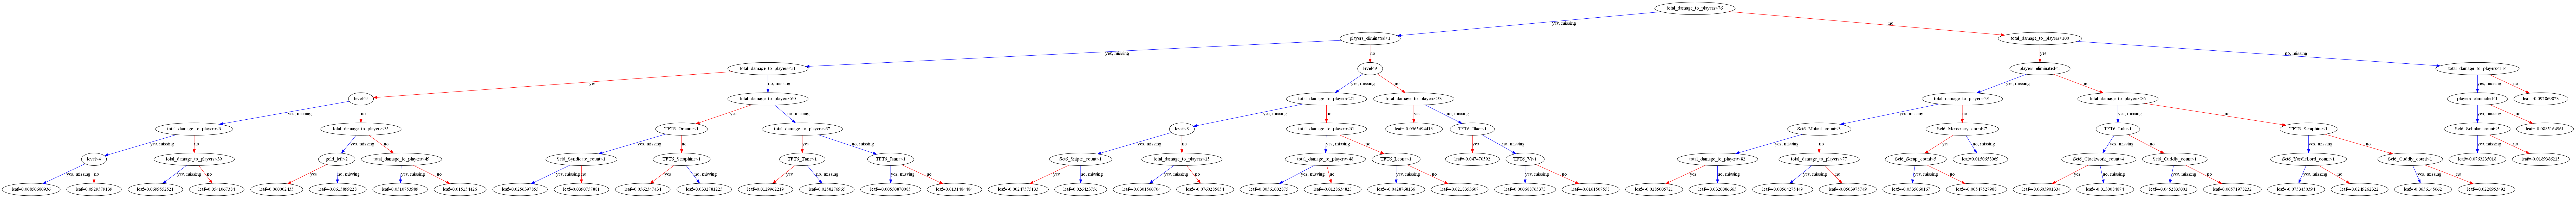

In [27]:
%matplotlib inline
xgb.plot_tree(model)
fig = plt.gcf()
fig.set_size_inches(400, 400)
fig.savefig('../figures/tree.jpeg')

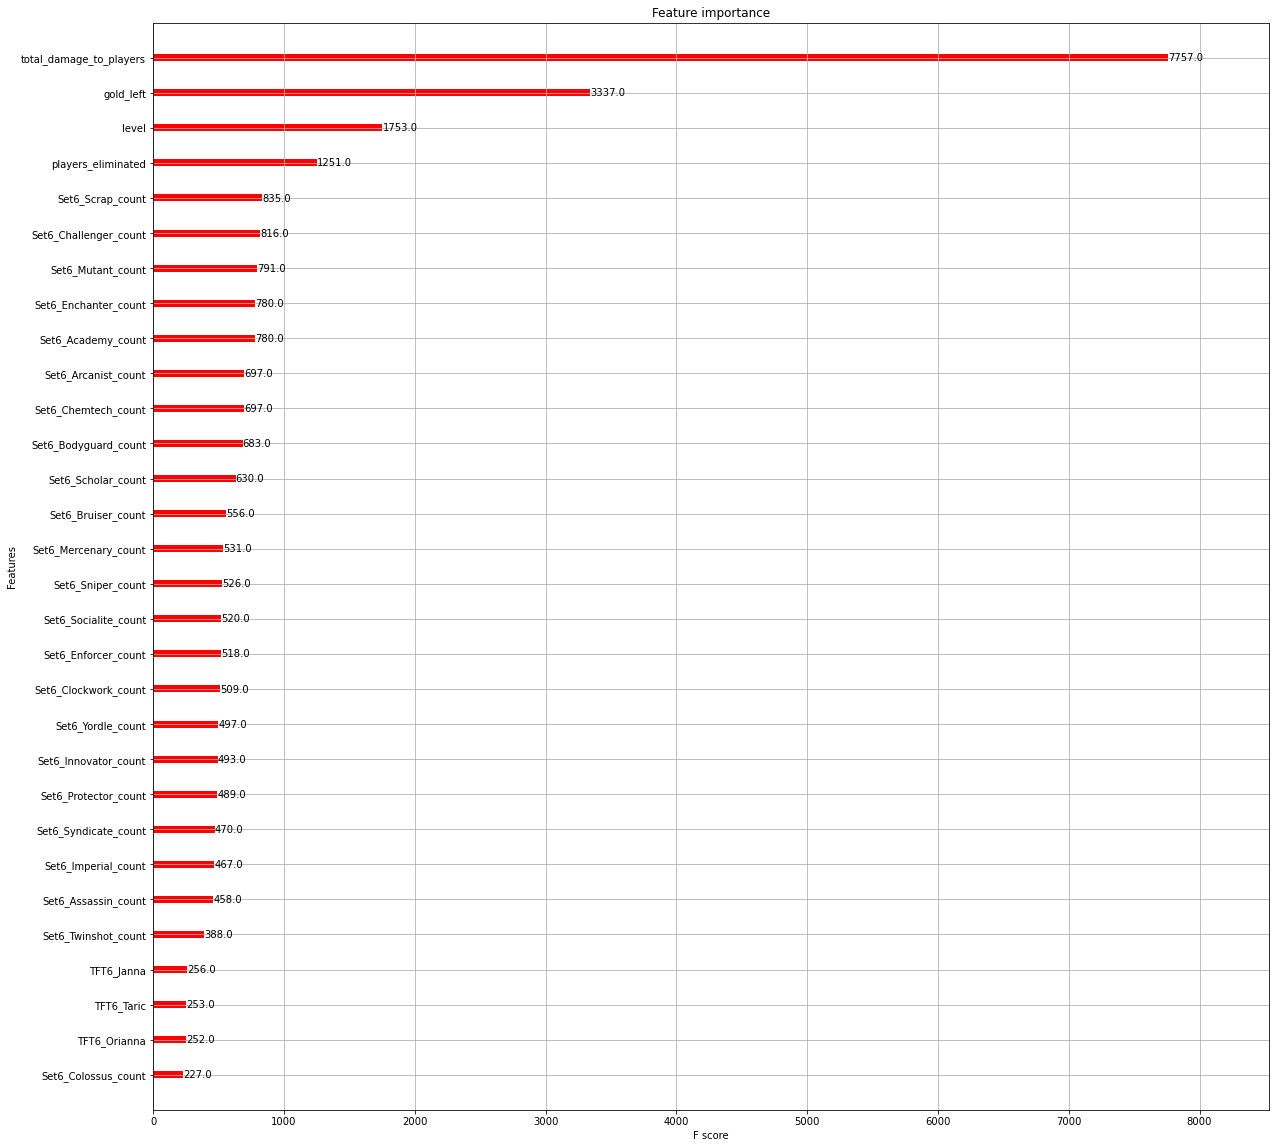

In [32]:
ax = xgb.plot_importance(model, color='red', max_num_features=30)
fig = ax.figure
fig.set_size_inches(20, 20)
fig.savefig('../figures/feature_importance')

In [23]:
predictions = (df.drop(columns='placement').groupby('MATCH_ID')
               .apply(lambda x: predict(model, x)))

In [24]:
avg_ndcg(train_data, predictions)

0.9889102722831227

In [25]:
avg_ndcg(test_data, predictions)

0.9884819202882391

In [32]:
null_ndcg(df, predictions)

0.8405792411171148